# Inverse Iteration Method for Eigenvalue Problems

## Introduction

**Inverse iteration** (also known as **inverse power method**) is a fundamental numerical algorithm for computing eigenvectors of a matrix. Given an approximation to an eigenvalue, inverse iteration rapidly converges to the corresponding eigenvector. This makes it particularly valuable when we have good eigenvalue estimates (e.g., from the QR algorithm) but need the associated eigenvectors.

## Mathematical Foundation

### The Eigenvalue Problem

For a matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$, we seek eigenvalue-eigenvector pairs $(\lambda, \mathbf{v})$ satisfying:

$$\mathbf{A}\mathbf{v} = \lambda \mathbf{v}$$

### Inverse Iteration Algorithm

Given a shift $\mu$ (an approximation to an eigenvalue $\lambda$), inverse iteration exploits the fact that $(\mathbf{A} - \mu \mathbf{I})^{-1}$ has eigenvalues:

$$\frac{1}{\lambda_i - \mu}$$

where $\lambda_i$ are the eigenvalues of $\mathbf{A}$. If $\mu \approx \lambda_j$, then $\frac{1}{\lambda_j - \mu}$ is the dominant eigenvalue of $(\mathbf{A} - \mu \mathbf{I})^{-1}$, and the power method applied to this inverse matrix converges rapidly to the eigenvector $\mathbf{v}_j$.

### Algorithm Steps

1. Start with initial guess $\mathbf{v}^{(0)}$ (typically random)
2. For $k = 0, 1, 2, \ldots$ until convergence:
   - Solve $(\mathbf{A} - \mu \mathbf{I})\mathbf{w}^{(k+1)} = \mathbf{v}^{(k)}$
   - Normalize: $\mathbf{v}^{(k+1)} = \frac{\mathbf{w}^{(k+1)}}{\|\mathbf{w}^{(k+1)}\|}$

### Convergence Analysis

The convergence rate is determined by the ratio:

$$\rho = \left| \frac{\lambda_j - \mu}{\lambda_{nearest} - \mu} \right|$$

where $\lambda_{nearest}$ is the eigenvalue second-closest to $\mu$. When $\mu$ is close to $\lambda_j$, this ratio is very small, leading to rapid (often cubic) convergence.

### Rayleigh Quotient Refinement

The eigenvalue estimate can be refined using the Rayleigh quotient:

$$\lambda \approx \rho(\mathbf{v}) = \frac{\mathbf{v}^T \mathbf{A} \mathbf{v}}{\mathbf{v}^T \mathbf{v}}$$

This provides a more accurate eigenvalue estimate as the eigenvector converges.

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

np.random.seed(42)

## Implementation

We implement inverse iteration with LU decomposition for efficient repeated solves.

In [2]:
def inverse_iteration(A, mu, tol=1e-10, max_iter=100):
    """
    Inverse iteration to find eigenvector corresponding to eigenvalue near mu.
    
    Parameters
    ----------
    A : ndarray
        Square matrix (n x n)
    mu : float
        Shift (approximation to desired eigenvalue)
    tol : float
        Convergence tolerance
    max_iter : int
        Maximum number of iterations
        
    Returns
    -------
    eigenvalue : float
        Refined eigenvalue estimate (Rayleigh quotient)
    eigenvector : ndarray
        Corresponding eigenvector
    residuals : list
        History of residual norms for convergence analysis
    """
    n = A.shape[0]
    
    # Initial random vector
    v = np.random.randn(n)
    v = v / np.linalg.norm(v)
    
    # Shifted matrix
    A_shifted = A - mu * np.eye(n)
    
    # LU factorization for efficient repeated solves
    lu, piv = linalg.lu_factor(A_shifted)
    
    residuals = []
    
    for k in range(max_iter):
        # Solve (A - mu*I) * w = v
        w = linalg.lu_solve((lu, piv), v)
        
        # Normalize
        w_norm = np.linalg.norm(w)
        v_new = w / w_norm
        
        # Rayleigh quotient for eigenvalue estimate
        eigenvalue = np.dot(v_new, A @ v_new)
        
        # Compute residual ||Av - lambda*v||
        residual = np.linalg.norm(A @ v_new - eigenvalue * v_new)
        residuals.append(residual)
        
        # Check convergence
        if residual < tol:
            return eigenvalue, v_new, residuals
        
        v = v_new
    
    return eigenvalue, v, residuals

## Example 1: Symmetric Matrix

We first demonstrate inverse iteration on a symmetric matrix, which has real eigenvalues and orthogonal eigenvectors.

In [3]:
# Create a symmetric positive definite matrix
n = 5
B = np.random.randn(n, n)
A_sym = B @ B.T + np.eye(n)  # Ensure positive definiteness

# Get true eigenvalues for reference
true_eigenvalues, true_eigenvectors = np.linalg.eigh(A_sym)
print("True eigenvalues:", true_eigenvalues)

# Target the smallest eigenvalue
target_idx = 0
mu = true_eigenvalues[target_idx] + 0.1  # Slightly perturbed shift

print(f"\nTarget eigenvalue: {true_eigenvalues[target_idx]:.6f}")
print(f"Initial shift mu: {mu:.6f}")

True eigenvalues: [ 1.05094072  2.68383256  4.01560023  5.58313201 14.29471652]

Target eigenvalue: 1.050941
Initial shift mu: 1.150941


In [4]:
# Run inverse iteration
eigenvalue, eigenvector, residuals = inverse_iteration(A_sym, mu)

print(f"\nComputed eigenvalue: {eigenvalue:.10f}")
print(f"True eigenvalue:     {true_eigenvalues[target_idx]:.10f}")
print(f"Absolute error:      {abs(eigenvalue - true_eigenvalues[target_idx]):.2e}")

# Check eigenvector accuracy (up to sign)
true_vec = true_eigenvectors[:, target_idx]
dot_product = abs(np.dot(eigenvector, true_vec))
print(f"\nEigenvector alignment |v·v_true|: {dot_product:.10f}")
print(f"Iterations to converge: {len(residuals)}")


Computed eigenvalue: 1.0509407217
True eigenvalue:     1.0509407217
Absolute error:      4.44e-16

Eigenvector alignment |v·v_true|: 1.0000000000
Iterations to converge: 9


## Example 2: Effect of Shift Quality

We investigate how the quality of the initial shift $\mu$ affects convergence speed.

In [5]:
# Create test matrix
n = 10
B = np.random.randn(n, n)
A_test = B @ B.T + 2 * np.eye(n)

true_eigs = np.linalg.eigvalsh(A_test)
target_eig = true_eigs[2]  # Target the 3rd smallest eigenvalue

print(f"Target eigenvalue: {target_eig:.6f}")

# Test different shift qualities
perturbations = [0.5, 0.1, 0.01, 0.001]
convergence_histories = {}

for perturb in perturbations:
    mu = target_eig + perturb
    _, _, residuals = inverse_iteration(A_test, mu, tol=1e-12, max_iter=50)
    convergence_histories[perturb] = residuals
    print(f"Perturbation {perturb}: converged in {len(residuals)} iterations")

Target eigenvalue: 2.675017
Perturbation 0.5: converged in 50 iterations
Perturbation 0.1: converged in 17 iterations
Perturbation 0.01: converged in 8 iterations
Perturbation 0.001: converged in 5 iterations


## Convergence Visualization

We plot the convergence behavior for different shift qualities.

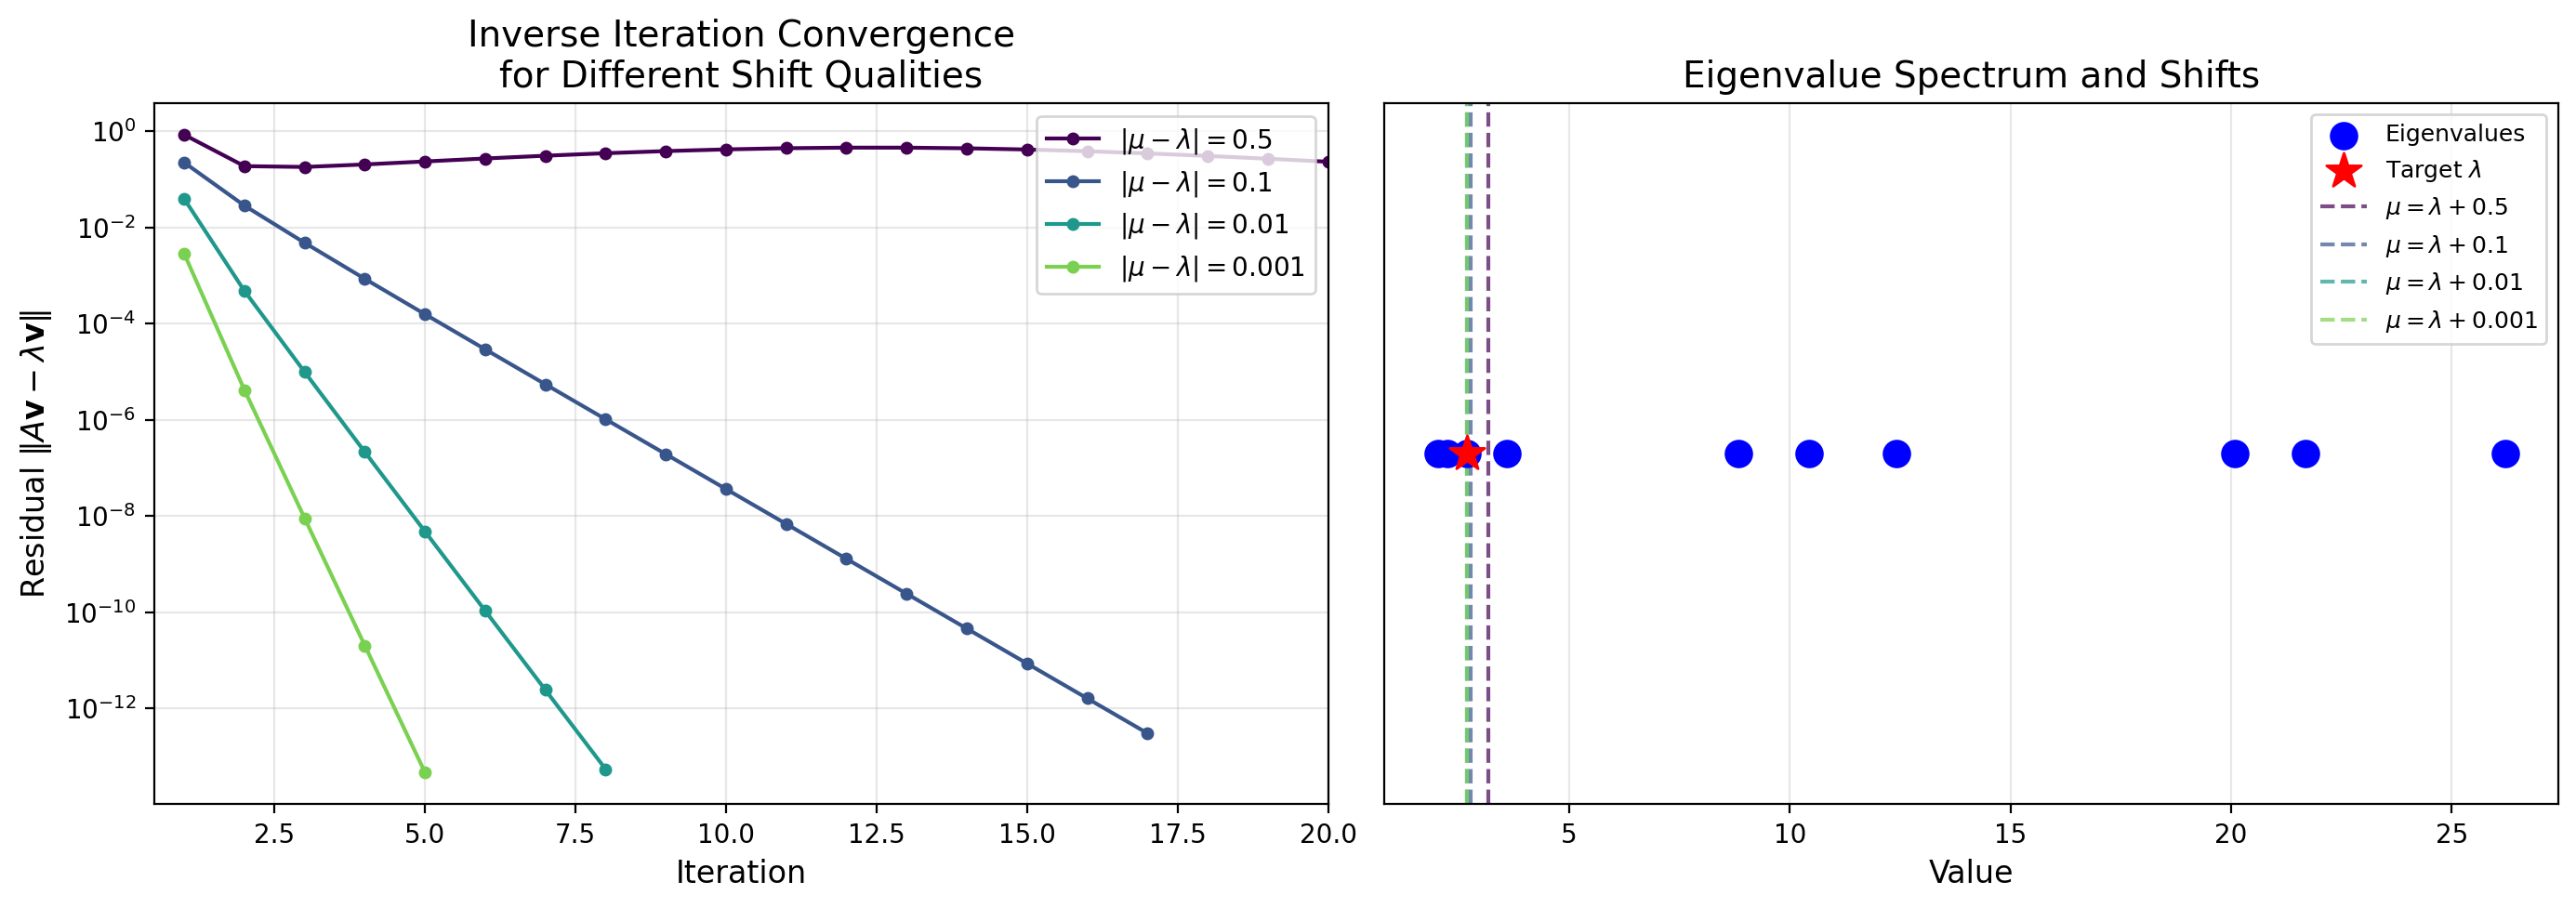


Plot saved to 'plot.png'


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Convergence histories
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(perturbations)))

for (perturb, residuals), color in zip(convergence_histories.items(), colors):
    ax1.semilogy(range(1, len(residuals) + 1), residuals, 
                 'o-', color=color, label=f'$|\\mu - \\lambda| = {perturb}$',
                 markersize=4, linewidth=1.5)

ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Residual $\\|A\\mathbf{v} - \\lambda\\mathbf{v}\\|$', fontsize=12)
ax1.set_title('Inverse Iteration Convergence\nfor Different Shift Qualities', fontsize=14)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.5, 20)

# Plot 2: Eigenvalue spectrum and shifts
ax2 = axes[1]

# Plot all eigenvalues
ax2.scatter(true_eigs, np.zeros_like(true_eigs), s=100, c='blue', 
            marker='o', label='Eigenvalues', zorder=5)

# Highlight target eigenvalue
ax2.scatter([target_eig], [0], s=200, c='red', marker='*', 
            label='Target $\\lambda$', zorder=6)

# Show shifts
for i, perturb in enumerate(perturbations):
    shift = target_eig + perturb
    ax2.axvline(shift, color=colors[i], linestyle='--', alpha=0.7,
                label=f'$\\mu = \\lambda + {perturb}$')

ax2.set_xlabel('Value', fontsize=12)
ax2.set_title('Eigenvalue Spectrum and Shifts', fontsize=14)
ax2.legend(loc='upper right', fontsize=9)
ax2.set_yticks([])
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('inverse_iteration_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Rayleigh Quotient Iteration

An improvement over standard inverse iteration is **Rayleigh Quotient Iteration (RQI)**, which updates the shift $\mu$ at each iteration using the current Rayleigh quotient. This achieves locally cubic convergence.

$$\mu^{(k+1)} = \rho(\mathbf{v}^{(k)}) = \frac{(\mathbf{v}^{(k)})^T \mathbf{A} \mathbf{v}^{(k)}}{(\mathbf{v}^{(k)})^T \mathbf{v}^{(k)}}$$

In [7]:
def rayleigh_quotient_iteration(A, mu_init, tol=1e-10, max_iter=20):
    """
    Rayleigh Quotient Iteration for eigenvalue/eigenvector computation.
    
    Parameters
    ----------
    A : ndarray
        Square matrix (n x n)
    mu_init : float
        Initial shift
    tol : float
        Convergence tolerance
    max_iter : int
        Maximum iterations
        
    Returns
    -------
    eigenvalue : float
        Computed eigenvalue
    eigenvector : ndarray
        Corresponding eigenvector
    residuals : list
        Convergence history
    """
    n = A.shape[0]
    v = np.random.randn(n)
    v = v / np.linalg.norm(v)
    mu = mu_init
    
    residuals = []
    
    for k in range(max_iter):
        # Solve (A - mu*I) * w = v
        try:
            w = np.linalg.solve(A - mu * np.eye(n), v)
        except np.linalg.LinAlgError:
            # Singular matrix means we've found exact eigenvalue
            break
        
        # Normalize
        v = w / np.linalg.norm(w)
        
        # Update shift with Rayleigh quotient
        mu = np.dot(v, A @ v)
        
        # Compute residual
        residual = np.linalg.norm(A @ v - mu * v)
        residuals.append(residual)
        
        if residual < tol:
            break
    
    return mu, v, residuals

In [8]:
# Compare standard inverse iteration with RQI
mu_init = target_eig + 0.3  # Moderate perturbation

# Standard inverse iteration
_, _, residuals_std = inverse_iteration(A_test, mu_init, tol=1e-14, max_iter=50)

# Rayleigh quotient iteration
_, _, residuals_rqi = rayleigh_quotient_iteration(A_test, mu_init, tol=1e-14, max_iter=50)

print(f"Standard inverse iteration: {len(residuals_std)} iterations")
print(f"Rayleigh quotient iteration: {len(residuals_rqi)} iterations")

Standard inverse iteration: 45 iterations
Rayleigh quotient iteration: 5 iterations


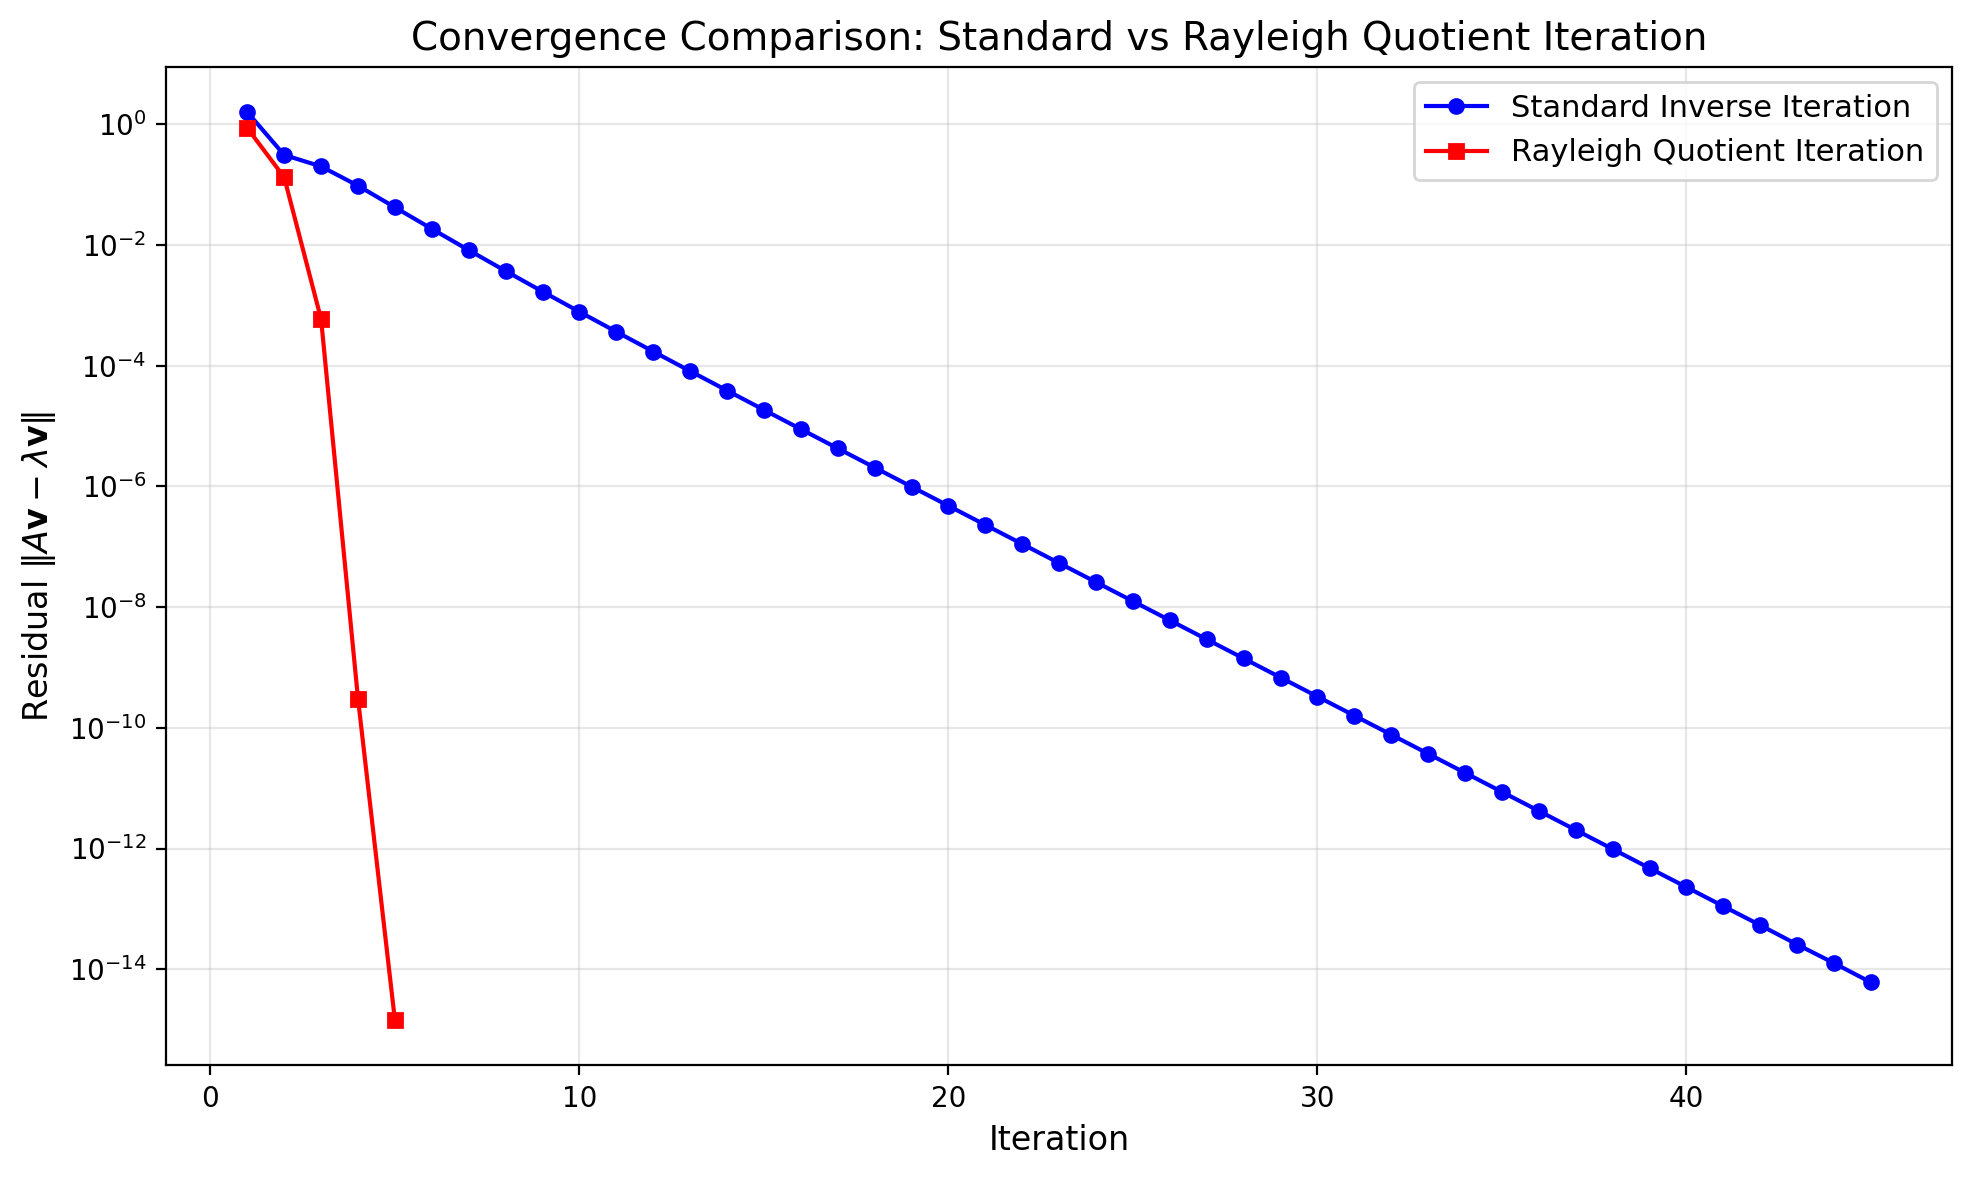

In [9]:
# Visualize the comparison
plt.figure(figsize=(10, 6))

plt.semilogy(range(1, len(residuals_std) + 1), residuals_std, 
             'b-o', label='Standard Inverse Iteration', markersize=5)
plt.semilogy(range(1, len(residuals_rqi) + 1), residuals_rqi, 
             'r-s', label='Rayleigh Quotient Iteration', markersize=5)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Residual $\\|A\\mathbf{v} - \\lambda\\mathbf{v}\\|$', fontsize=12)
plt.title('Convergence Comparison: Standard vs Rayleigh Quotient Iteration', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Practical Considerations

### When to Use Inverse Iteration

1. **Eigenvector refinement**: When eigenvalues are known (e.g., from QR algorithm) but eigenvectors are needed
2. **Selective computation**: When only a few specific eigenpairs are required
3. **Sparse matrices**: Inverse iteration only requires solving linear systems, which can be done efficiently for sparse matrices

### Numerical Stability

- Use LU decomposition with partial pivoting for solving linear systems
- When $\mu$ is very close to an eigenvalue, $(A - \mu I)$ becomes nearly singular
- In practice, this near-singularity doesn't cause problems because the solution direction is preserved

### Complexity

- Each iteration requires solving an $n \times n$ linear system: $O(n^3)$ for dense matrices
- With LU pre-factorization: initial $O(n^3)$, then $O(n^2)$ per iteration
- For sparse matrices, cost depends on the sparsity structure

In [10]:
# Demonstrate finding multiple eigenvectors
print("Finding all eigenvectors using inverse iteration:\n")

computed_eigenvectors = []
for i, eig in enumerate(true_eigs):
    # Use exact eigenvalue as shift (best case)
    eigenvalue, eigenvector, _ = inverse_iteration(A_test, eig, tol=1e-12)
    computed_eigenvectors.append(eigenvector)
    
    # Verify orthogonality with previously computed eigenvectors
    if i > 0:
        max_dot = max(abs(np.dot(eigenvector, v)) for v in computed_eigenvectors[:-1])
        print(f"Eigenvalue {i+1}: {eigenvalue:.6f}, max |v_i · v_j|: {max_dot:.2e}")
    else:
        print(f"Eigenvalue {i+1}: {eigenvalue:.6f}")

Finding all eigenvectors using inverse iteration:

Eigenvalue 1: 2.019327
Eigenvalue 2: 2.243353, max |v_i · v_j|: 8.26e-16
Eigenvalue 3: 2.675017, max |v_i · v_j|: 4.78e-15
Eigenvalue 4: 3.595800, max |v_i · v_j|: 4.12e-15
Eigenvalue 5: 8.833683, max |v_i · v_j|: 6.29e-16
Eigenvalue 6: 10.432383, max |v_i · v_j|: 3.00e-15
Eigenvalue 7: 12.409104, max |v_i · v_j|: 5.11e-15
Eigenvalue 8: 20.076512, max |v_i · v_j|: 4.41e-15
Eigenvalue 9: 21.687412, max |v_i · v_j|: 1.45e-15
Eigenvalue 10: 26.209839, max |v_i · v_j|: 1.58e-15


## Summary

Inverse iteration is a powerful and efficient algorithm for computing eigenvectors when good eigenvalue approximations are available. Key takeaways:

1. **Rapid convergence**: The method converges quickly when the shift is close to the target eigenvalue
2. **Flexibility**: Can target any eigenvalue by choosing an appropriate shift
3. **Efficiency**: Only requires solving linear systems, making it suitable for large sparse matrices
4. **Enhancement**: Rayleigh quotient iteration further accelerates convergence by dynamically updating the shift

The algorithm forms a fundamental building block in modern eigenvalue solvers and is often used in conjunction with other methods like the QR algorithm or Arnoldi iteration.